4.autoencoder
obj-to learn about autoencoder and developing autocoders for anomaly detection
An autoencoder is a type of artificial neural network used in unsupervised machine learning and dimensionality reduction. It is designed to learn efficient representations of input data, typically by reducing its dimensionality while maintaining its essential features. Autoencoders consist of an encoder and a decoder, and their primary purpose is to reconstruct the input data.

Here's how an autoencoder works and its key components:

1. **Encoder:** The encoder is the first part of the autoencoder and is responsible for transforming the input data into a lower-dimensional representation. It consists of one or more layers of neurons, typically using nonlinear activation functions. The encoder's output, often referred to as the "encoding" or "latent space," is a compressed representation of the input data.

2. **Bottleneck Layer:** The bottleneck layer, located in the middle of the encoder, is where the data is most compressed. The dimensionality of this layer is usually much smaller than the input data's dimension.

3. **Decoder:** The decoder is the second part of the autoencoder and aims to reconstruct the input data from the encoding. Like the encoder, the decoder also consists of one or more layers, but its architecture is symmetric to the encoder. The decoder's output is an attempt to reconstruct the original input data.

4. **Objective Function (Loss Function):** Autoencoders are trained to minimize the difference between the input data and the data reconstructed by the decoder. This is typically done using a loss function, which quantifies the dissimilarity between the input and the reconstructed data. Common loss functions include mean squared error (MSE) for continuous data or binary cross-entropy for binary data.

The training process of an autoencoder involves feeding the same data into both the encoder and decoder. The model learns to represent the input data in a more compact form in the encoder's bottleneck layer and then attempts to reconstruct the original data in the decoder. During training, the encoder and decoder weights are adjusted using backpropagation and gradient descent to minimize the chosen loss function.

Autoencoders have several practical applications:

1. **Dimensionality Reduction:** Autoencoders can be used to reduce the dimensionality of data, which can be beneficial for tasks like feature extraction, visualization, or data compression.

2. **Anomaly Detection:** Anomalies in data may result in higher reconstruction errors when using autoencoders. This property makes autoencoders useful for anomaly detection in various domains.

3. **Data Denoising:** Autoencoders can be used to denoise data by training on noisy data and having the decoder attempt to reconstruct clean data.

4. **Feature Learning:** Autoencoders can automatically learn useful features from data, making them valuable for transfer learning and feature engineering in other machine learning tasks.

5. **Image Generation:** Variational autoencoders (a type of autoencoder) are used for generative tasks, such as image generation. They can generate new data samples that are similar to the training data.

Autoencoders come in various forms, including standard autoencoders, convolutional autoencoders (for image data), and variational autoencoders (VAEs), which extend autoencoders to generate data probabilistically and are widely used in generative models. The choice of autoencoder type and architecture depends on the specific problem and data at hand.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras import Sequential
from tensorflow.keras import layers, losses

In [24]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = df.values
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [25]:
labels = raw_data[:,-1]
data = raw_data[:,0:-1]

In [26]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

In [27]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [28]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anamalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

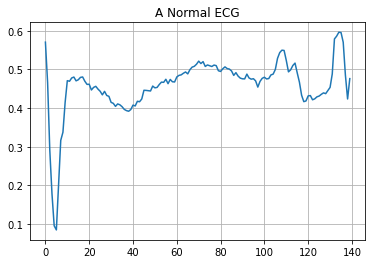

In [29]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

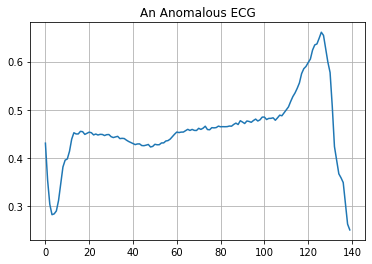

In [30]:
plt.grid()
plt.plot(np.arange(140), anamalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

**Build the mode**

In [31]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [32]:
autoencoder.compile(optimizer='adam', loss='mae')


In [33]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 3s 228ms/step - loss: 0.0570 - val_loss: 0.0523
Epoch 2/20
5/5 [==============================] - 0s 41ms/step - loss: 0.0538 - val_loss: 0.0509
Epoch 3/20
5/5 [==============================] - 0s 56ms/step - loss: 0.0503 - val_loss: 0.0486
Epoch 4/20
5/5 [==============================] - 0s 37ms/step - loss: 0.0466 - val_loss: 0.0461
Epoch 5/20
5/5 [==============================] - 0s 36ms/step - loss: 0.0426 - val_loss: 0.0445
Epoch 6/20
5/5 [==============================] - 0s 52ms/step - loss: 0.0387 - val_loss: 0.0424
Epoch 7/20
5/5 [==============================] - 0s 41ms/step - loss: 0.0350 - val_loss: 0.0411
Epoch 8/20
5/5 [==============================] - 0s 49ms/step - loss: 0.0320 - val_loss: 0.0396
Epoch 9/20
5/5 [==============================] - 0s 54ms/step - loss: 0.0297 - val_loss: 0.0388
Epoch 10/20
5/5 [==============================] - 0s 50ms/step - loss: 0.0281 - val_loss: 0.0379
Epoch 11/20
5/5 [===========

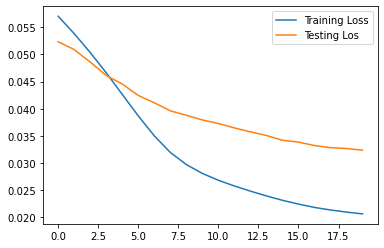

In [34]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Testing Los")
plt.legend()

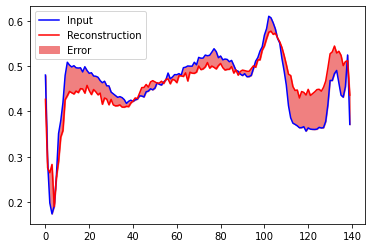

In [35]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

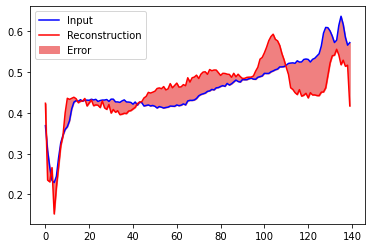

In [36]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

74/74 [==============================] - 1s 4ms/step


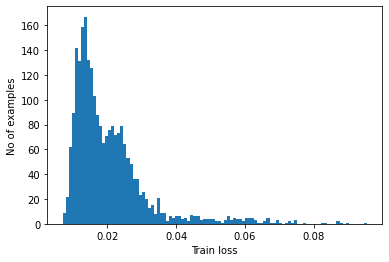

In [37]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=100)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [38]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.031802226


In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=100)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

14/14 [==============================] - 0s 123us/step


In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [41]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571
